In [6]:
pip install --upgrade mne

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
import mne
import numpy as np
from sklearn.preprocessing import StandardScaler

# GDF 파일 경로 지정
filename = "/home/work/HCOH/BCICIV_2a_gdf/A01T.gdf"

# GDF 파일 읽기
raw = mne.io.read_raw_gdf(filename, preload=True)

# 이벤트 시간 위치 찾기
events, _ = mne.events_from_annotations(raw)

# 중복된 채널 이름 수정
def fix_duplicate_channel_names(raw):
    counts = {}
    new_names = []
    for name in raw.info['ch_names']:
        if name in counts:
            counts[name] += 1
            new_name = f"{name}-{counts[name]}"
        else:
            counts[name] = 1
            new_name = name
        new_names.append(new_name)
    rename_dict = dict(zip(raw.info['ch_names'], new_names))
    mne.rename_channels(raw.info, rename_dict)

fix_duplicate_channel_names(raw)

# EOG 채널 제거하고 원하는 EEG 채널만 선택
raw.info['bads'] += ['EOG-left', 'EOG-central', 'EOG-right']
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude='bads')

# 250Hz에서 125Hz로 다운샘플링
raw.resample(125, npad="auto")

# 7-35 Hz 대역 통과 필터 적용
raw.filter(7., 35., picks=picks, fir_design='firwin')

# 4개의 클래스에 대한 288개의 이벤트에서 3초 시간 간격의 에포크 추출
tmin, tmax = 0., 3.  # 큐 시작 후 3초
event_id = dict({'769': 7, '770': 8, '771': 9, '772': 10})

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)

# 신호의 평균을 0으로, 분산을 1로 스케일링
scaler = StandardScaler()

X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
n_epochs, n_channels, n_times = X.shape

# 각 채널별로 평균 0, 분산 1로 스케일링
for i in range(n_epochs):
    for j in range(n_channels):
        X[i, j, :] = scaler.fit_transform(X[i, j, :].reshape(-1, 1)).flatten()

# y 값(라벨) 설정
y = epochs.events[:, -1]

print(f"Processed EEG data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Extracting EDF parameters from /home/work/HCOH/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 207 samples (1.656 s)

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 376 original time points ...
167 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_166/3762398406.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)


Processed EEG data shape: (121, 22, 376)
Labels shape: (121,)


In [17]:
y

array([10,  9,  8,  7,  7,  8,  9, 10,  8,  9,  7,  7,  7, 10,  8,  8,  7,
        7,  9,  7,  8, 10, 10,  9,  7, 10, 10,  8, 10, 10,  8,  7,  8,  9,
        9,  9, 10,  9,  7, 10,  8,  9,  8,  9, 10,  8,  9,  7,  7,  7, 10,
        8,  7,  9,  7,  9,  8, 10,  7,  9,  9,  7,  9,  8, 10, 10, 10,  9,
        7, 10,  8, 10,  8,  7,  9,  8,  7,  9,  9,  7,  9, 10, 10,  8,  7,
        8, 10,  8, 10,  9,  8,  8,  8,  9, 10,  7,  8, 10,  7,  9,  9, 10,
        7,  7,  9,  8, 10, 10, 10,  8,  7,  9,  8, 10,  7, 10,  9,  8, 10,
       10,  7])

In [18]:
import mne
import numpy as np
from sklearn.preprocessing import StandardScaler

# GDF 파일 경로 지정
filename = "/home/work/HCOH/BCICIV_2a_gdf/A01T.gdf"

# GDF 파일 읽기
raw = mne.io.read_raw_gdf(filename, preload=True)

# 이벤트 시간 위치 찾기
events, _ = mne.events_from_annotations(raw)

# 중복된 채널 이름 수정
def fix_duplicate_channel_names(raw):
    counts = {}
    new_names = []
    for name in raw.info['ch_names']:
        if name in counts:
            counts[name] += 1
            new_name = f"{name}-{counts[name]}"
        else:
            counts[name] = 1
            new_name = name
        new_names.append(new_name)
    rename_dict = dict(zip(raw.info['ch_names'], new_names))
    mne.rename_channels(raw.info, rename_dict)

fix_duplicate_channel_names(raw)

# EOG 채널 제거하고 원하는 EEG 채널만 선택
raw.info['bads'] += ['EOG-left', 'EOG-central', 'EOG-right']
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude='bads')

# 250Hz에서 125Hz로 다운샘플링
raw.resample(125, npad="auto")

# 4개의 클래스에 대한 288개의 이벤트에서 3초 시간 간격의 에포크 추출
tmin, tmax = 0., 3.  # 큐 시작 후 3초
event_id = dict({'769': 7, '770': 8, '771': 9, '772': 10})

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)

# 신호의 평균을 0으로, 분산을 1로 스케일링
scaler = StandardScaler()

X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
n_epochs, n_channels, n_times = X.shape

# 각 채널별로 평균 0, 분산 1로 스케일링
for i in range(n_epochs):
    for j in range(n_channels):
        X[i, j, :] = scaler.fit_transform(X[i, j, :].reshape(-1, 1)).flatten()

# y 값(라벨) 설정
y = epochs.events[:, -1]

print(f"Processed EEG data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Extracting EDF parameters from /home/work/HCOH/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/usr/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 376 original time points ...
167 bad epochs dropped


/tmp/ipykernel_166/2096256767.py:48: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)


Processed EEG data shape: (121, 22, 376)
Labels shape: (121,)


In [19]:
y

array([10,  9,  8,  7,  7,  8,  9, 10,  8,  9,  7,  7,  7, 10,  8,  8,  7,
        7,  9,  7,  8, 10, 10,  9,  7, 10, 10,  8, 10, 10,  8,  7,  8,  9,
        9,  9, 10,  9,  7, 10,  8,  9,  8,  9, 10,  8,  9,  7,  7,  7, 10,
        8,  7,  9,  7,  9,  8, 10,  7,  9,  9,  7,  9,  8, 10, 10, 10,  9,
        7, 10,  8, 10,  8,  7,  9,  8,  7,  9,  9,  7,  9, 10, 10,  8,  7,
        8, 10,  8, 10,  9,  8,  8,  8,  9, 10,  7,  8, 10,  7,  9,  9, 10,
        7,  7,  9,  8, 10, 10, 10,  8,  7,  9,  8, 10,  7, 10,  9,  8, 10,
       10,  7])

In [8]:
import pandas as pd
import numpy as np

# 가정: X는 (121, 22, 376) 형태의 EEG 데이터이고, y는 레이블 (121,) 입니다.

# 각 채널의 데이터를 DataFrame으로 변환
# epoch마다 데이터를 전부 펼쳐서 행으로 만듭니다.
epoch_dfs = []
for epoch_idx in range(X.shape[0]):
    epoch_data = X[epoch_idx, :, :]  # 각 epoch에 대한 데이터 (22, 376)
    epoch_df = pd.DataFrame(epoch_data.T, columns=[f'ch_{i}' for i in range(1, X.shape[1] + 1)])
    epoch_df['epoch'] = epoch_idx + 1  # 각 행이 어떤 epoch에 속하는지 추가
    epoch_dfs.append(epoch_df)

# 모든 epoch의 데이터를 하나의 DataFrame으로 결합
combined_df = pd.concat(epoch_dfs, ignore_index=True)

# 각 epoch의 레이블을 결합
labels_df = pd.DataFrame({'epoch': np.repeat(np.arange(1, X.shape[0] + 1), X.shape[2]),
                          'label': np.repeat(y, X.shape[2])})

# 데이터와 레이블을 병합
final_df = pd.merge(combined_df, labels_df, on='epoch')

# 결과 출력
print(final_df)

              ch_1      ch_2      ch_3      ch_4      ch_5      ch_6  \
0        -0.637232 -0.874646 -0.570164 -0.741646 -0.596358 -0.798655   
1        -0.637232 -0.874646 -0.570164 -0.741646 -0.596358 -0.798655   
2        -0.637232 -0.874646 -0.570164 -0.741646 -0.596358 -0.798655   
3        -0.637232 -0.874646 -0.570164 -0.741646 -0.596358 -0.798655   
4        -0.637232 -0.874646 -0.570164 -0.741646 -0.596358 -0.798655   
...            ...       ...       ...       ...       ...       ...   
17106491  0.323410 -0.425648 -0.173034  0.209801  0.006763 -0.148383   
17106492  0.323410 -0.425648 -0.173034  0.209801  0.006763 -0.148383   
17106493  0.323410 -0.425648 -0.173034  0.209801  0.006763 -0.148383   
17106494  0.323410 -0.425648 -0.173034  0.209801  0.006763 -0.148383   
17106495  0.323410 -0.425648 -0.173034  0.209801  0.006763 -0.148383   

              ch_7      ch_8      ch_9     ch_10  ...     ch_15     ch_16  \
0        -0.075720 -0.546965 -0.364167 -0.511728  ...  0.1

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.1,
                                                    shuffle = True,
                                                    random_state = 21)

In [22]:
X_train.shape

(108, 22, 376)

In [23]:
y_train

array([ 9,  9,  7, 10,  8,  9, 10, 10,  7, 10, 10, 10,  8,  7,  7,  7,  7,
        9, 10,  7, 10,  8,  7,  7, 10,  8,  8,  9,  8,  7,  9,  9,  8, 10,
        8,  7,  9,  9, 10,  7,  8, 10,  9, 10,  9,  7,  7,  7, 10,  9,  7,
        8, 10, 10,  8,  7,  8, 10,  8, 10,  9,  8,  8, 10, 10,  9, 10,  9,
       10,  9,  8, 10,  7,  9,  7,  9,  8,  9, 10, 10, 10,  8,  9,  8,  9,
       10,  7,  8,  9,  7,  7,  9,  9,  8,  7, 10,  8,  8,  9,  7,  9,  9,
        8,  7,  7,  8,  7,  7])

In [24]:
from tensorflow.keras.utils import to_categorical

# 라벨 7, 8, 9, 10을 0, 1, 2, 3으로 변환
y_train = y_train - 7
y_test = y_test - 7

# 원-핫 인코딩 적용
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

print(y_train)

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0.

In [25]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [26]:
import keras
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Input
from keras.layers import Dense, Flatten, Dropout

In [27]:
input_layer = Input(shape=(22,376))

conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
flat = Flatten()(conv1)
dens = Dense(64, activation = "relu")(flat)
outputs = Dense(4, activation = "sigmoid")(dens)

model = keras.Model(input_layer, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 22, 376)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            72256     
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                81984     
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 154500 (603.52 KB)
Trainable params: 154500 (603.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

# 모델 학습
history = model.fit(X_train, y_train, epochs=30, verbose=True, validation_split=0.1)

print(f"Processed Training Data Shape: {X_train.shape}")
print(f"Processed Test Data Shape: {X_test.shape}")

Epoch 1/30
4/4 [==============================] - 1s 54ms/step - loss: 1.7356 - accuracy: 0.2474 - val_loss: 2.2674 - val_accuracy: 0.1818
Epoch 2/30
4/4 [==============================] - 0s 15ms/step - loss: 0.7147 - accuracy: 0.7320 - val_loss: 2.3346 - val_accuracy: 0.1818
Epoch 3/30
4/4 [==============================] - 0s 14ms/step - loss: 0.3247 - accuracy: 0.9175 - val_loss: 2.2705 - val_accuracy: 0.1818
Epoch 4/30
4/4 [==============================] - 0s 14ms/step - loss: 0.1478 - accuracy: 0.9794 - val_loss: 2.2018 - val_accuracy: 0.4545
Epoch 5/30
4/4 [==============================] - 0s 14ms/step - loss: 0.0737 - accuracy: 0.9897 - val_loss: 2.4106 - val_accuracy: 0.4545
Epoch 6/30
4/4 [==============================] - 0s 14ms/step - loss: 0.0624 - accuracy: 0.9897 - val_loss: 2.8391 - val_accuracy: 0.4545
Epoch 7/30
4/4 [==============================] - 0s 14ms/step - loss: 0.0244 - accuracy: 1.0000 - val_loss: 3.2086 - val_accuracy: 0.3636
Epoch 8/30
4/4 [===========

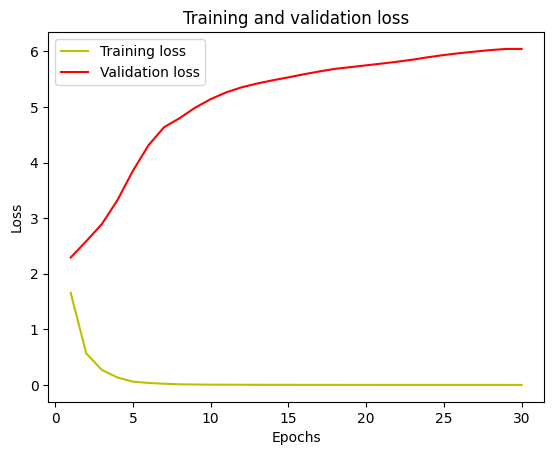

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

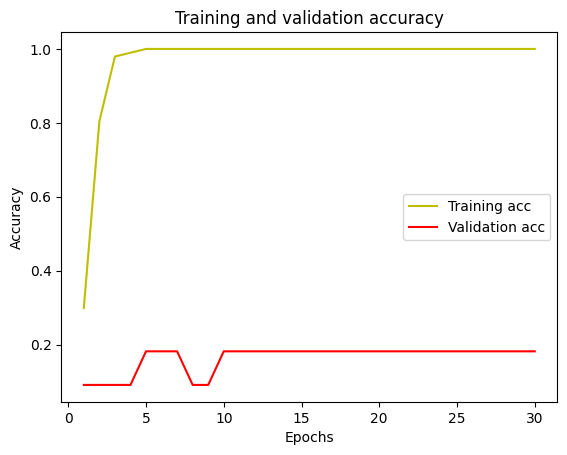

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:

#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix


y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test_onehot,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

1/1 [==============================] - 0s 164ms/step


In [14]:
#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.25      0.40         4
           2       0.00      0.00      0.00         2
           3       0.50      1.00      0.67         5

    accuracy                           0.46        13
   macro avg       0.38      0.31      0.27        13
weighted avg       0.50      0.46      0.38        13

[[0 0 1 1]
 [0 1 1 2]
 [0 0 0 2]
 [0 0 0 5]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
